In [14]:
import netket as nk
import netket.experimental as nkx
from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc
from netket.models.slater import Slater2nd, MultiSlater2nd
from scipy.sparse.linalg import eigsh
import numpy as np
import scipy.sparse.linalg
import jax
import jax.numpy as jnp
import json
import matplotlib.pyplot as plt

import sys, os
sys.path.append('/Users/wttai/Documents/Jupyter/machine_learning/common_lib')
sys.path.append('/home1/wttai/machine_learning/common_lib')
#from models import get_qwz_graph, get_qwz_Ham, get_qwz_exchange_graph

from networks import *
from helper import get_ed_data

In [3]:
graph = nk.graph.Grid([2,2], pbc = True)
graph.edges()

[(2, 3), (0, 2), (1, 3), (0, 1)]

In [13]:
from netket_system import NetketHubbardSystem

L = 2
Lx = L
Ly = L
N_fill = 2 #Lx * Ly
pbc = True
t = 1.0
U = 1.0
bias = 0.1
args = {'U': U, 't': t, 'bias': bias}

n_iter = 2000

system = NetketHubbardSystem(L, N = N_fill, pbc = pbc, args = args)

Ham = system.get_hamiltonian()

hi = system.hi
exchange_graph = system.get_exchange_graph()

learning_rate = 0.001
diag_shift = 0.01

# Exact diagonalization

evals, evecs = get_ed_data(Ham, k = 2)
E_gs = evals[0]
print(evals)

Exact ground state energy: -3.104422563533215
[-3.10442256 -3.04230102]


In [14]:
# Create the Slater determinant model
model = LogSlaterDeterminant(hi, complex=complex)

# Define the Metropolis-Hastings sampler
#sa = nk.sampler.ExactSampler(hi)
sa = nk.sampler.MetropolisExchange(hi, graph = exchange_graph)

# Define the optimizer
op = nk.optimizer.Sgd(learning_rate=learning_rate)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=diag_shift, holomorphic=complex)

vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=32)
gs = nk.VMC(Ham, op, variational_state=vstate, preconditioner=preconditioner)

In [15]:
s, p = 1, -1
#dummy_array = [0 for i in range(L**2)]
corrs = {'ss': [0 for i in range(L**2)]}
for i in range(L**2):
    corrs['ss'][i] = system.corr_func(i)
    #corrs[f"nc{i}nc0"] = corr_func(i)

# Slater Determinant

In [16]:
complex = False
max_restarts = -1  # Maximum number of restart attempts
restart_count = 0  # Counter to track restarts
converged = False  # Flag to check if the run converged

# Create the Slater determinant model
model = LogSlaterDeterminant(hi, complex=complex)

# Define the Metropolis-Hastings sampler
#sa = nk.sampler.ExactSampler(hi)
sa = nk.sampler.MetropolisExchange(hi, graph = exchange_graph)

# Define the optimizer
op = nk.optimizer.Sgd(learning_rate=learning_rate)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=diag_shift, holomorphic=complex)

# Function to run the VMC simulation
def run_simulation(n_iter = 50):
    # Create the VMC (Variational Monte Carlo) driver
    vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=32)
    gs = nk.VMC(Ham, op, variational_state=vstate, preconditioner=preconditioner)
    
    # Construct the logger to visualize the data later on
    slater_log = nk.logging.RuntimeLog()
    
    # Run the optimization for a short number of iterations (e.g., 50)
    gs.run(n_iter=n_iter, out=slater_log, obs=corrs)
    
    return gs, slater_log

# Main loop for checking convergence and restarting if needed
while restart_count < max_restarts and not converged:
    slater_log = run_simulation()
    
    print(slater_log['Energy']['Variance'])
    # Check if the standard deviation of the energy at the last iteration is too high
    if slater_log['Energy']['Variance'][-1] > 1:
        print(f"Bad convergence detected. Restarting attempt {restart_count + 1} of {max_restarts}...")
        restart_count += 1
        if restart_count >= max_restarts  :
            raise Exception("Failed to converge after 3 attempts. Aborting the run.")
    else:
        converged = True
        print("Good convergence. Continuing with the full run...")



# If converged, run the full simulation
print("Starting full simulation...")
# You can extend this part to run the full simulation for more iterations
gs, slater_log = run_simulation(n_iter = n_iter)  # Re-run with the full iteration count
print("Full simulation completed.")


Starting full simulation...


  0%|          | 0/2000 [00:00<?, ?it/s]

Full simulation completed.


In [29]:
print(slater_log['ss'][0]['Mean'][:10])

[2.+0.j 2.+0.j 2.+0.j 2.+0.j 2.+0.j 2.+0.j 2.+0.j 2.+0.j 2.+0.j 2.+0.j]


In [17]:
sd_energy = slater_log['Energy']['Mean'][-1]
error = abs((sd_energy - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : (-2.9417021864348505-1.666712739611248e-09j)
Relative error   : 0.05241566628518796


In [18]:
model = LogNeuralJastrowSlater(hi, hidden_units=Lx * Ly, complex = complex)

# Define a Metropolis exchange sampler
#sa = nk.sampler.ExactSampler(hi) 
sa = nk.sampler.MetropolisExchange(hi, graph = exchange_graph)

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=learning_rate)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=diag_shift, holomorphic = complex)
gs = nk.VMC(Ham, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
nj_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=n_iter, out=nj_log)

  0%|          | 0/2000 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['acceptance', 'Energy'],)

In [19]:
sd_energy = vstate.expect(Ham)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -3.07423+0.00000j ± 0.00021 [σ²=0.00017, R̂=1.0019]
Relative error   : 0.00972495338376582


In [26]:
complex = True

In [29]:
# Create a neural backflow wave function
model = LogNeuralBackflow(hi, hidden_units=Lx * Ly, complex = complex)

# Define a Metropolis exchange sampler
#sa = nk.sampler.MetropolisExchange(hi, graph=graph)
#sa = nk.sampler.MetropolisExchange(hi, graph = exchange_graph)
sa = nk.sampler.ExactSampler(hi) 

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=learning_rate)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=diag_shift, holomorphic = complex)
gs = nk.VMC(Ham, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
bf_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
gs.run(n_iter=n_iter, out=bf_log)

/home1/wttai/.conda/envs/netket/lib/python3.12/site-packages/netket/vqs/mc/mc_state/state.py:252: UserWarning: An exact sampler does not need to discard samples. Setting n_discard_per_chain to 0.
  self.n_discard_per_chain = n_discard_per_chain


  0%|          | 0/2000 [00:00<?, ?it/s]

(RuntimeLog():
  keys = ['Energy'],)

In [22]:
sd_energy = vstate.expect(Ham)
error = abs((sd_energy.mean - E_gs) / E_gs)

print(f"Optimized energy : {sd_energy}")
print(f"Relative error   : {error}")

Optimized energy : -3.073629-0.000000j ± 0.000028 [σ²=0.000003, R̂=1.0012]
Relative error   : 0.009919237399442778


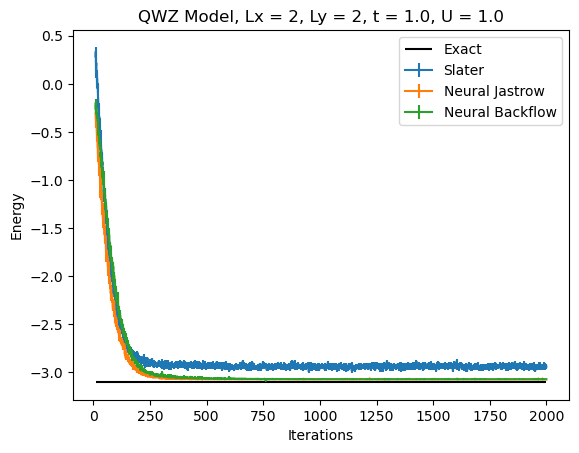

In [24]:
logged_data = (slater_log.data,nj_log.data,bf_log.data)
labels = ("Slater","Neural Jastrow","Neural Backflow")

from matplotlib import pyplot as plt

start = 10

end = n_iter

for data,label in zip(logged_data,labels):
    plt.errorbar(data["Energy"].iters[start:end], data["Energy"].Mean.real[start:end], yerr=data["Energy"].Sigma[start:end],label=label)

plt.hlines([E_gs], xmin=start, xmax=end, color='black', label="Exact")
plt.title(f"QWZ Model, Lx = {Lx}, Ly = {Ly}, t = {t}, U = {U}")

plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()

In [19]:
data.keys()

dict_keys(['acceptance', 'Energy'])